In [1]:
import csv
import os, sys
import pickle
import math
from queue import PriorityQueue

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

mpl.rcParams['figure.dpi']= 300

from sklearn.metrics import accuracy_score
from torchinfo import summary
from tqdm import tqdm
from utils import (mean_absolute_percentage_error,
                   load_or_create_dataset_graph,
                   mean_square_error, root_mean_square_error)

from models.models import Transformer_Ranking

from torch.nn import Linear, ReLU, Dropout
from torch_geometric.nn import Sequential, GCNConv, JumpingKnowledge
from torch_geometric.nn import global_mean_pool

from random import randint
import wandb

GPU = 1
LR = 0.0001
BS = 128
W = 20
T = 250
LOG = False
D_MODEL = 5
N_HEAD  = 5
DROPOUT = 0.2
D_FF    = 64
ENC_LAYERS = 1
DEC_LAYERS = 1
MAX_EPOCH = 50
USE_POS_ENCODING = False
USE_GRAPH = True
HYPER_GRAPH = True
USE_KG = False
PREDICTION_PROBLEM = 'value'
RUN = randint(1, 100000)

tau_choices = [50, 75, 125, 250]
tau_positions = [1, 5, 20, 50, 75, 100, 125, 250]

MODEL = "ours"

print("Experiment SP500 W=20 Run 1 Without Relation KG")
FAST = False
if FAST == True:
    LOG = False

LOG = True
if LOG:
    wandb_config = {
        'Prediction Problem': PREDICTION_PROBLEM,
        'Learning Rate':LR,
        'Batch Size': BS,
        'Window Size': W,
        'Prediction Steps': T,
        'Model': MODEL,
        'Optimizer': 'ADAM',
        'Preprocessing': ['Window Divide Min'],
        'KG': ['NO Company'],
        'Transformer Params': [D_MODEL, N_HEAD, DROPOUT, D_FF, ENC_LAYERS, DEC_LAYERS, USE_POS_ENCODING]
    }

    wandb.init(project="KG-Stock-Graph"+str(T), config=wandb_config)

INDEX = "nasdaq100" 

save_path = "data/pickle/"+INDEX+"/graph_data-P25-W"+str(W)+"-T"+str(T)+"_"+str(PREDICTION_PROBLEM)+".pkl"


dataset, company_to_id, graph, hyper_data = load_or_create_dataset_graph(INDEX=INDEX, W=W, T=T, save_path=save_path, problem=PREDICTION_PROBLEM, fast=FAST)


num_nodes = len(company_to_id.keys())

if torch.cuda.is_available():
    device = torch.device("cuda:"+str(GPU))
else:
    device = torch.device("cpu")


if not HYPER_GRAPH:
    graph_nodes_batch = torch.zeros(graph.x.shape[0]).to(device)
    graph = graph.to(device)
    graph_data = {
        'x': graph.x,
        'edge_list': graph.edge_index,
        'batch': graph_nodes_batch
    }
else:
    x, hyperedge_index = hyper_data['x'].to(device), hyper_data['hyperedge_index'].to(device)

    print("Graph details: ", x.shape, hyperedge_index.shape)
    graph_data = {
        'x': x,
        'hyperedge_index': hyperedge_index
    }

if USE_KG:
    with open('./kg/profile_and_relationship/wikidata/'+INDEX+'_relations_kg.pkl', 'rb') as f:
        relation_kg = pickle.load(f)['kg']
    head, relation, tail = relation_kg[0], relation_kg[1], relation_kg[2]
    head, relation, tail = head.to(device), relation.to(device), tail.to(device)
    relation_kg = (head, relation, tail)
else:
    relation_kg = None

def rank_loss(prediction, ground_truth):
    all_one = torch.ones(prediction.shape[0], 1, dtype=torch.float32).to(device)
    prediction = prediction.unsqueeze(dim=1)
    ground_truth = ground_truth.unsqueeze(dim=1)
    #print(prediction.shape, ground_truth.shape, base_price.shape)
    return_ratio = prediction - 1
    true_return_ratio = ground_truth - 1

    pre_pw_dif = torch.sub(
        return_ratio @ all_one.t(),                  # C x C
        all_one @ return_ratio.t()                   # C x C
    )
    gt_pw_dif = torch.sub(
        all_one @ true_return_ratio.t(),
        true_return_ratio @ all_one.t()
    )

    rank_loss = torch.mean(
        F.relu(-1*pre_pw_dif * gt_pw_dif )
    )
   
    return rank_loss 

def evaluate(prediction, ground_truth, K):
    return_ratio = prediction - 1
    true_return_ratio = ground_truth - 1

    #print("True top k: ", torch.topk(true_return_ratio.squeeze(), k=3, dim=0))
    #print("Predicted top k: ", torch.topk(return_ratio.squeeze(), k=3, dim=0))
    
    obtained_return_ratio = true_return_ratio[torch.topk(return_ratio, k=K, dim=0)[1]].mean()

    #return_ratio = -1*return_ratio
    #obtained_return_ratio += true_return_ratio[torch.topk(return_ratio.squeeze(), k=K, dim=0)[1]].mean()
    #obtained_return_ratio /= 2

    target_obtained_return_ratio = torch.topk(true_return_ratio, k=K, dim=0)[0].mean()

    expected_return_ratio = torch.topk(return_ratio.squeeze(), k=K, dim=0)[0].mean()

    random = torch.randint(0, prediction.shape[0]-1, (K,))
    random_return_ratio = true_return_ratio[random].mean()

    a_cat_b, counts = torch.cat([torch.topk(return_ratio.squeeze(), k=K, dim=0)[1], torch.topk(true_return_ratio.squeeze(), k=K, dim=0)[1]]).unique(return_counts=True)
    accuracy = a_cat_b[torch.where(counts.gt(1))].shape[0] / K

    return obtained_return_ratio, target_obtained_return_ratio, expected_return_ratio, random_return_ratio, accuracy




/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Experiment SP500 W=20 Run 1 Without Relation KG


wandb: Currently logged in as: kawinm (statsml-csa-iisc). Use `wandb login --relogin` to force relogin
wandb: ERROR Failed to sample metric: Not Supported


--- File exists: Loading Dataset ---


wandb: ERROR Failed to serialize metric: division by zero


Graph details:  torch.Size([83, 8]) torch.Size([2, 304])


In [11]:
from models.models import Saturation

top_k_choice = [1, 3, 5, 10]

# ----------- Main Training Loop -----------
def predict(loader, desc):
    epoch_loss, mape, move_loss, rmse_returns_loss, mae_loss = 0, 0, 0, 0, 0
    mini, maxi = float("infinity"), 0
    rr, true_rr, exp_rr, ran_rr, accuracy = torch.zeros(4).to(device), torch.zeros(4).to(device), torch.zeros(4).to(device), torch.zeros(4).to(device), torch.zeros(4).to(device)
    
    #tqdm_loader = tqdm(loader)

    wandb.watch(model, log="all") 
    
    yb_store, yhat_store = [], []
    for xb, company, yb, scale, move_target in loader:
        xb      = xb.to(device) 
        yb      = yb.to(device) 
        scale   = scale.to(device)
        move_target = move_target.to(device)

        y_hat, kg_loss, hold_pred = model(xb, yb, graph_data, relation_kg)
        y_hat = y_hat.squeeze()
        true_return_ratio = yb.squeeze() 

        #print("TRR: ", float(true_return_ratio.min()), float(true_return_ratio.max()))
        #print("Pred: ", float(y_hat.min()), float(y_hat.max()))

        loss = F.mse_loss(y_hat, true_return_ratio) #+ rank_loss(y_hat, true_return_ratio)
        if USE_KG:
            loss += kg_loss.mean()

        if model.training:
            opt_c.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt_c.step()


        yb_store.append(yb.detach().cpu().numpy())
        yhat_store.append(y_hat.detach().cpu().numpy())
        
        if not model.training:
            for index, k in enumerate(top_k_choice):
                crr, ctrr, cerr, crrr, cacc = evaluate(y_hat, true_return_ratio, k)
                ran_rr[index] += crrr
                true_rr[index] += ctrr
                rr[index] += crr
                exp_rr[index] += cerr
                accuracy[index] += cacc

        mae_loss += F.l1_loss(y_hat, true_return_ratio).item()
        rmse_returns_loss += F.mse_loss(y_hat, true_return_ratio).item()
        mape += mean_absolute_percentage_error(y_hat, true_return_ratio)

        move_pred = torch.where(y_hat >= 1, 1, 0)
        move_loss += (move_pred.int() == move_target).float().mean()

        mini = min(mini, y_hat.min().item())
        maxi = max(maxi, y_hat.max().item())  
        
        epoch_loss += float(loss)

    epoch_loss /= len(loader)
    rmse_returns_loss /= len(loader)
    move_loss  /= len(loader)
    mape /= len(loader)
    rr /= len(loader) 
    true_rr /= len(loader)
    exp_rr /= len(loader)
    ran_rr /= len(loader)
    accuracy /= len(loader)
    mae_loss /= len(loader)

    print("[{0}] Movement Prediction Accuracy: {1}, MAPE: {2}".format(desc, move_loss.item(), mape.item()))
    print("[{0}] Range of predictions min: {1} max: {2}".format(desc, mini, maxi))
    print("[{0}] Epoch: {1} MSE: {2} RMSE: {3} Loss: {4} MAE: {5}".format(desc, ep+1, rmse_returns_loss, rmse_returns_loss ** (1/2), epoch_loss, mae_loss))
    
    for index, k in enumerate(top_k_choice):
        print("[{0}] Top {5} Return Ratio: {1} True Return Ratio: {2} Expected Return Ratio: {3} Random Return Ratio: {4} Accuracy: {6}".format(desc, rr[index], true_rr[index], exp_rr[index], ran_rr[index], k, accuracy[index]))
    
    log = {'MSE': epoch_loss, 'RMSE': epoch_loss ** (1/2), "MOVEMENT ACC": move_loss, "MAPE": mape}
    
    if LOG:
        wandb.log(log)
    #    wandb.watch(model)

    # matplotlib plot
    #mpl.rcParams['figure.dpi']= 300
    #plt.plot(np.array(yb_store).reshape(-1, 83), c='r')
    #plt.plot(np.array(yhat_store).reshape(-1, 83), c='b')
    #plt.show()

    return epoch_loss, rr, true_rr, exp_rr, ran_rr, move_loss, mape, accuracy, mae_loss

for tau in tau_choices:
    tau_pos = tau_positions.index(tau)

    print("Tau: ", tau, "Tau Position: ", tau_pos)

    # ----------- Batching the data -----------
    def collate_fn(instn):
        
        # df: shape: BS x Companies x W+1 x 5 (5 is the number of features)
        df = torch.Tensor(np.array([np.array([x[0] for x in ins]) for ins in instn])).unsqueeze(dim=3)
        
        for i in range(1, 5):
            df1 = torch.Tensor(np.array([np.array([x[0] for x in ins]) for ins in instn])).unsqueeze(dim=3)
            df = torch.cat((df, df1), dim=3)

        company = torch.Tensor(np.array([np.array([x[5] for x in ins]) for ins in instn])).long()

        # Shape: BS x Companies
        target = torch.Tensor(np.array([np.array([x[7][tau_pos] for x in ins]) for ins in instn])).squeeze(dim=2)

        # Shape: Companies x 1
        scale = torch.Tensor(np.array([np.array([x[8] for x in ins]) for ins in instn]))

        # Shape: BS x Companies
        movement = target >= 1
        return (df, company, target, scale, movement.int())


    start_time = 0
    test_mean_rr, test_mean_trr, test_mean_err, test_mean_rrr = torch.zeros(4).to(device), torch.zeros(4).to(device), torch.zeros(4).to(device), torch.zeros(4).to(device)
    test_mean_move, test_mean_mape, test_mean_mae = 0, 0, 0

    test_mean_acc = torch.zeros(4).to(device)
    print(len(dataset))
    for phase in range(1, 26):
        print("Phase: ", phase)
        train_loader    = DataLoader(dataset[start_time:start_time+250], 10, shuffle=True, collate_fn=collate_fn, num_workers=1)
        val_loader      = DataLoader(dataset[start_time+250:start_time+300], 1, shuffle=True, collate_fn=collate_fn)
        test_loader     = DataLoader(dataset[start_time+300:start_time+400], 1, shuffle=False, collate_fn=collate_fn)

        start_time += 100

        model  = Transformer_Ranking(W, T, D_MODEL, N_HEAD, ENC_LAYERS, DEC_LAYERS, D_FF, DROPOUT, USE_POS_ENCODING, USE_GRAPH, HYPER_GRAPH, USE_KG, num_nodes)
        #print(model)
        model.to(device)

        opt_c = torch.optim.Adam(model.parameters(), lr = LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4)

        prev_val_loss = float("infinity")
        for ep in range(MAX_EPOCH):
            print("Epoch: " + str(ep+1))
            
            model.train()
            train_epoch_loss, rr, trr, err, rrr, move, mape, accuracy, mae = predict(train_loader, "TRAINING")

            model.eval()
            with torch.no_grad():
                val_epoch_loss, rr, trr, err, rrr, move, mape, accuracy, mae  = predict(val_loader, "VALIDATION")

            #plot(val_loader)

            if (ep > MAX_EPOCH//2 or ep > 10) and prev_val_loss > val_epoch_loss:
                print("Saving Model")
                torch.save(model.state_dict(), "models/saved_models/best_model_"+INDEX+str(W)+"_"+str(T)+"_"+str(RUN)+".pt")
                prev_val_loss = val_epoch_loss

        model.load_state_dict(torch.load("models/saved_models/best_model_"+INDEX+str(W)+"_"+str(T)+"_"+str(RUN)+".pt"))

        model.eval()
        with torch.no_grad():
            test_epoch_loss, rr, trr, err, rrr, move, mape, accuracy, mae = predict(test_loader, "TESTING")
            test_mean_rr += rr
            test_mean_trr += trr
            test_mean_err += err
            test_mean_rrr += rrr
            test_mean_acc += accuracy
            test_mean_move += float(move)
            test_mean_mape += float(mape)
            test_mean_mae += float(mae)
            for index, k in enumerate(top_k_choice):
                print("[Mean - {0}] Top {5} Return Ratio: {1} True Return Ratio: {2} Expected Return Ratio: {3} Random Return Ratio: {4} Accuracy: {6}".format("TESTING", test_mean_rr[index]/phase, test_mean_trr[index]/phase, test_mean_err[index]/phase, test_mean_rrr[index]/phase, k, test_mean_acc[index]/phase))
            print("[Mean - {0}] Movement Accuracy: {1} Mean MAPE: {2} Mean MAE: {3}".format("TESTING", test_mean_move/phase, test_mean_mape/phase, test_mean_mae/phase))
        if LOG:
            wandb.save('model.py')

    phase = 20
    print("Tau: ", tau)
    for index, k in enumerate(top_k_choice):
        print("[Mean - {0}] Top {5} {1} {2} {3} {4} {6}".format("TESTING", test_mean_rr[index]/phase, test_mean_trr[index]/phase, test_mean_err[index]/phase, test_mean_rrr[index]/phase, k, test_mean_acc[index]/phase))
    print("[Mean - {0}] {1} {2} {3}".format("TESTING", test_mean_move/phase, test_mean_mape/phase, test_mean_mae/phase))
    gdh

Tau:  50 Tau Position:  3
2530
Phase:  1
Epoch: 1
[TRAINING] Movement Prediction Accuracy: 0.3941686451435089, MAPE: 2174.150390625
[TRAINING] Range of predictions min: -0.10264767706394196 max: 0.35429006814956665
[TRAINING] Epoch: 1 MSE: 0.854455623626709 RMSE: 0.9243676885453694 Loss: 0.854455623626709 MAE: 0.9108234643936157
[TRAINING] Top 1 Return Ratio: 0.0 True Return Ratio: 0.0 Expected Return Ratio: 0.0 Random Return Ratio: 0.0 Accuracy: 0.0
[TRAINING] Top 3 Return Ratio: 0.0 True Return Ratio: 0.0 Expected Return Ratio: 0.0 Random Return Ratio: 0.0 Accuracy: 0.0
[TRAINING] Top 5 Return Ratio: 0.0 True Return Ratio: 0.0 Expected Return Ratio: 0.0 Random Return Ratio: 0.0 Accuracy: 0.0
[TRAINING] Top 10 Return Ratio: 0.0 True Return Ratio: 0.0 Expected Return Ratio: 0.0 Random Return Ratio: 0.0 Accuracy: 0.0
[VALIDATION] Movement Prediction Accuracy: 0.20433732867240906, MAPE: 511.7800598144531
[VALIDATION] Range of predictions min: 0.10720691829919815 max: 0.20837636291980743


In [1]:
import torch
import torch.nn as nn 
import math 
import torch.nn.functional as F

from torch_geometric.nn import Sequential, GCNConv, JumpingKnowledge, HypergraphConv
from torch_geometric.nn import global_mean_pool

from torchkge.models.translation import TorusEModel

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout, max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # TODO: Check div term, correct or wrong
        div_term = torch.exp(torch.arange(0, 2*d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)[:, 0::2]
        #print(pe.shape, position.shape, div_term.shape)
        pe[:, 1::2] = torch.cos(position * div_term)[:, 1::2]
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)
        # return x

# ----------- Model -----------
class Transformer_Ranking(nn.Module):
    
    def __init__(self, W, T, D_MODEL, N_HEAD, ENC_LAYERS, DEC_LAYERS, D_FF, DROPOUT, USE_POS_ENCODING = False, USE_GRAPH = False, HYPER_GRAPH = True, USE_KG = True, NUM_NODES = 87):
        super().__init__()

        SEC_EMB, n = 5, 1 # 1 For LSTM Embedding
        if USE_GRAPH:
            n += 1
        if USE_KG:
            n += 1

        self.embeddings = nn.Embedding(105, 10)

        self.pos_enc_x = PositionalEncoding(d_model=D_MODEL, dropout=DROPOUT, max_len=W)
        self.pos_enc_y = PositionalEncoding(d_model=D_MODEL, dropout=DROPOUT, max_len=T)

        self.lstm_encoder = nn.LSTM(input_size = D_MODEL, hidden_size = D_MODEL, num_layers = ENC_LAYERS, batch_first = True, bidirectional = False)

        #encoder_layer = nn.TransformerEncoderLayer(d_model=D_MODEL, nhead=N_HEAD, dim_feedforward=D_FF, batch_first=True )
        #self.transformer_encoder_first = nn.TransformerEncoder(encoder_layer, num_layers=ENC_LAYERS)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=D_MODEL, nhead=N_HEAD, dim_feedforward=D_FF, batch_first=True )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=ENC_LAYERS)

        self.fc1 = nn.Linear(5, 5)
        self.fc2 = nn.Linear(1, D_MODEL)
        self.pred = nn.Linear(D_MODEL+(SEC_EMB*n), 1)
        self.pred2 = nn.Linear(5, 1)

        self.hold_pred = nn.Linear(D_MODEL+(SEC_EMB*n), 1)

        self.is_pos = USE_POS_ENCODING
        self.time_steps = T

        

        self.use_graph = USE_GRAPH
        self.is_hyper_graph = HYPER_GRAPH
        if self.use_graph:
            if self.is_hyper_graph:
                self.graph_model = Sequential('x, hyperedge_index', [
                        #(Dropout(p=0.5), 'x -> x'),
                        (HypergraphConv(8, 32, dropout=0.1), 'x, hyperedge_index -> x1'),
                        nn.LeakyReLU(inplace=True),
                        (HypergraphConv(32, 32, dropout=0.1), 'x1, hyperedge_index -> x2'),
                        nn.LeakyReLU(inplace=True),
                        
                        #(lambda x1, x2: [x1, x2], 'x1, x2 -> xs'),
                        #(JumpingKnowledge("cat", 64, num_layers=2), 'xs -> x'),
                        #(global_mean_pool, 'x, batch -> x'),
                        nn.Linear(32, SEC_EMB),
                    ])
            else:
                self.graph_model = Sequential('x, edge_index, batch', [
                            #(Dropout(p=0.5), 'x -> x'),
                            (GCNConv(8, 32), 'x, edge_index -> x1'),
                            nn.ReLU(inplace=True),
                            (GCNConv(32, 64), 'x1, edge_index -> x2'),
                            nn.ReLU(inplace=True),
                            #(lambda x1, x2: [x1, x2], 'x1, x2 -> xs'),
                            #(JumpingKnowledge("cat", 64, num_layers=2), 'xs -> x'),
                            #(global_mean_pool, 'x, batch -> x'),
                            nn.Linear(64, SEC_EMB),
                        ])
                
        self.use_kg = USE_KG
        if self.use_kg:
            self.relation_kge = TorusEModel(n_entities= NUM_NODES, n_relations = 57, emb_dim = SEC_EMB, dissimilarity_type='torus_L2')
        self.num_nodes = NUM_NODES

    def forward(self, xb, yb=None, graph=None, kg=None):
        if self.is_pos:
            xb = self.pos_enc_x(xb)
            yb = self.pos_enc_y(yb)
        #yb = torch.cat((yb, emb2), dim=2)

        # # Experiment 1
        xb = xb.reshape(-1, xb.shape[2], xb.shape[3])
        x, y = self.lstm_encoder(xb)
        xb = y[0]
        
        xb = xb.view(-1, self.num_nodes, xb.shape[2])
        # # Experiment 2
        #W,F = xb.shape[1], xb.shape[2]
        #xb = xb.unsqueeze(dim=0).view(1, -1, W*F)

        # # Experiment 3
        #x = self.transformer_encoder_first(xb).mean(dim=1)
        #xb = x.unsqueeze(dim=0)
        
        x = self.transformer_encoder(xb)               # x: [B, C, W*F]
        #x = torch.cat((x, emb2), dim=2)

        if self.use_graph and self.is_hyper_graph:
            g_emb = self.graph_model(graph['x'], graph['hyperedge_index']).unsqueeze(dim=0)
            g_emb = g_emb.repeat(x.shape[0], 1, 1)
            x = torch.cat((x, g_emb), dim=2)
        elif self.use_graph and not self.is_hyper_graph:
            g_emb = self.graph_model(graph['x'], graph['edge_list'], graph['batch'])
            #g_emb = g_emb.repeat(1, self.time_steps, 1)        
            x = torch.cat((x, g_emb), dim=1)
        
        kg_loss = torch.zeros(1)
        if self.use_kg:
            kg_loss = self.relation_kge.scoring_function(kg[0], kg[2], kg[1])
            kg_emb, rel_emb = self.relation_kge.get_embeddings()
            kg_emb = kg_emb.unsqueeze(dim=0)
            x = torch.cat((x, kg_emb), dim=2)

            self.relation_kge.normalize_parameters()

        x = torch.cat((x, xb), dim=2)

        price_pred = self.pred(x)
        #price_pred = F.leaky_relu(price_pred)
        #price_pred = F.relu(price_pred)

        hold_pred = self.hold_pred(x.mean(dim=1)).squeeze(dim=0)
            # x = F.relu(x)
            # x = self.pred2(x)
        return price_pred, kg_loss, hold_pred


# ----------- Model -----------
class Saturation(nn.Module):
    
    def __init__(self, W, T, D_MODEL, N_HEAD, ENC_LAYERS, DEC_LAYERS, D_FF, DROPOUT, USE_POS_ENCODING = False, USE_GRAPH = False, HYPER_GRAPH = True, USE_KG = True, NUM_NODES = 87):
        super().__init__()

        SEC_EMB, n = 5, 0 # 1 For LSTM Embedding
        if USE_GRAPH:
            n += 1
        if USE_KG:
            n += 1

        self.lstm_encoder = nn.Linear(D_MODEL, 1)
        self.transformer_encoder = nn.Linear(W, D_MODEL)

        self.use_graph = USE_GRAPH
        self.is_hyper_graph = HYPER_GRAPH
        if self.use_graph:
            if self.is_hyper_graph:
                self.graph_model = Sequential('x, hyperedge_index', [
                        #(Dropout(p=0.5), 'x -> x'),
                        (HypergraphConv(8, 32, dropout=0.1), 'x, hyperedge_index -> x1'),
                        nn.LeakyReLU(inplace=True),
                        (HypergraphConv(32, 32, dropout=0.1), 'x1, hyperedge_index -> x2'),
                        nn.LeakyReLU(inplace=True),
                        
                        #(lambda x1, x2: [x1, x2], 'x1, x2 -> xs'),
                        #(JumpingKnowledge("cat", 64, num_layers=2), 'xs -> x'),
                        #(global_mean_pool, 'x, batch -> x'),
                        nn.Linear(32, SEC_EMB),
                    ])
            else:
                self.graph_model = Sequential('x, edge_index, batch', [
                            #(Dropout(p=0.5), 'x -> x'),
                            (GCNConv(8, 32), 'x, edge_index -> x1'),
                            nn.ReLU(inplace=True),
                            (GCNConv(32, 64), 'x1, edge_index -> x2'),
                            nn.ReLU(inplace=True),
                            #(lambda x1, x2: [x1, x2], 'x1, x2 -> xs'),
                            #(JumpingKnowledge("cat", 64, num_layers=2), 'xs -> x'),
                            #(global_mean_pool, 'x, batch -> x'),
                            nn.Linear(64, SEC_EMB),
                        ])

        self.pred = nn.Linear(D_MODEL, 1)

    def forward(self, xb, yb=None, graph=None, kg=None):
        x = self.lstm_encoder(xb).squeeze()
        x = self.transformer_encoder(x)               # x: [B, C, W*F]

        if self.use_graph and self.is_hyper_graph:
            g_emb = self.graph_model(graph['x'], graph['hyperedge_index'])
            #g_emb = g_emb.repeat(1, self.time_steps, 1)
            #x = torch.cat((x, g_emb), dim=1)
        elif self.use_graph and not self.is_hyper_graph:
            g_emb = self.graph_model(graph['x'], graph['edge_list'], graph['batch'])
            #g_emb = g_emb.repeat(1, self.time_steps, 1)        
            #x = torch.cat((x, g_emb), dim=1)

        price_pred = self.pred(x)
        return price_pred, 0, 0




/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import csv
import os, sys
import pickle
import math
from queue import PriorityQueue

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

mpl.rcParams['figure.dpi']= 300

from sklearn.metrics import accuracy_score
from torchinfo import summary
from tqdm import tqdm
from utils import (mean_absolute_percentage_error,
                   load_or_create_dataset_graph,
                   mean_square_error, root_mean_square_error)

from models.models import Transformer_Ranking, Saturation

from torch.nn import Linear, ReLU, Dropout
from torch_geometric.nn import Sequential, GCNConv, JumpingKnowledge
from torch_geometric.nn import global_mean_pool

from random import randint
import wandb

GPU = 1
LR = 0.0001
BS = 128
W = 20
T = 250
LOG = False
D_MODEL = 20
N_HEAD  = 5
DROPOUT = 0.1
D_FF    = 1024
ENC_LAYERS = 1
DEC_LAYERS = 1
MAX_EPOCH = 25
USE_POS_ENCODING = False
USE_GRAPH = False
HYPER_GRAPH = False
USE_KG = False
PREDICTION_PROBLEM = 'value'
RUN = randint(1, 100000)
PLOT = False

tau_choices = [50, 75, 125, 250]
tau_positions = [1, 5, 20, 50, 75, 100, 125, 250]

MODEL = "ours"

print("Experiment SP500 P25 W=20 Run 1 Without Relation KG")
FAST = False
if FAST == True:
    LOG = False

if LOG:
    wandb_config = {
        'Prediction Problem': PREDICTION_PROBLEM,
        'Learning Rate':LR,
        'Batch Size': BS,
        'Window Size': W,
        'Prediction Steps': T,
        'Model': MODEL,
        'Optimizer': 'ADAM',
        'Preprocessing': ['Window Divide Min'],
        'KG': ['NO Company'],
        'Transformer Params': [D_MODEL, N_HEAD, DROPOUT, D_FF, ENC_LAYERS, DEC_LAYERS, USE_POS_ENCODING]
    }

    wandb.init(project="KG-Stock-Graph"+str(T), config=wandb_config)

INDEX = "nasdaq100" 
print(INDEX)

save_path = "data/pickle/"+INDEX+"/graph_data-P25-W"+str(W)+"-T"+str(T)+"_"+str(PREDICTION_PROBLEM)+".pkl"


dataset, company_to_id, graph, hyper_data = load_or_create_dataset_graph(INDEX=INDEX, W=W, T=T, save_path=save_path, problem=PREDICTION_PROBLEM, fast=FAST)

num_nodes = len(company_to_id.keys())

if torch.cuda.is_available():
    device = torch.device("cuda:"+str(GPU))
else:
    device = torch.device("cpu")


if not HYPER_GRAPH:
    graph_nodes_batch = torch.zeros(graph.x.shape[0]).to(device)
    graph = graph.to(device)
    graph_data = {
        'x': graph.x,
        'edge_list': graph.edge_index,
        'batch': graph_nodes_batch
    }
else:
    x, hyperedge_index = hyper_data['x'].to(device), hyper_data['hyperedge_index'].to(device)

    print("Graph details: ", x.shape, hyperedge_index.shape)
    graph_data = {
        'x': x,
        'hyperedge_index': hyperedge_index
    }

if USE_KG:
    with open('./kg/profile_and_relationship/wikidata/'+INDEX+'_relations_kg.pkl', 'rb') as f:
        relation_kg = pickle.load(f)['kg']
    head, relation, tail = relation_kg[0], relation_kg[1], relation_kg[2]
    head, relation, tail = head.to(device), relation.to(device), tail.to(device)
    relation_kg = (head, relation, tail)
else:
    relation_kg = None







Experiment SP500 P25 W=20 Run 1 Without Relation KG
nasdaq100
--- File exists: Loading Dataset ---


Tau:  50 Tau Position:  3
2530
Phase:  1
Epoch: 1


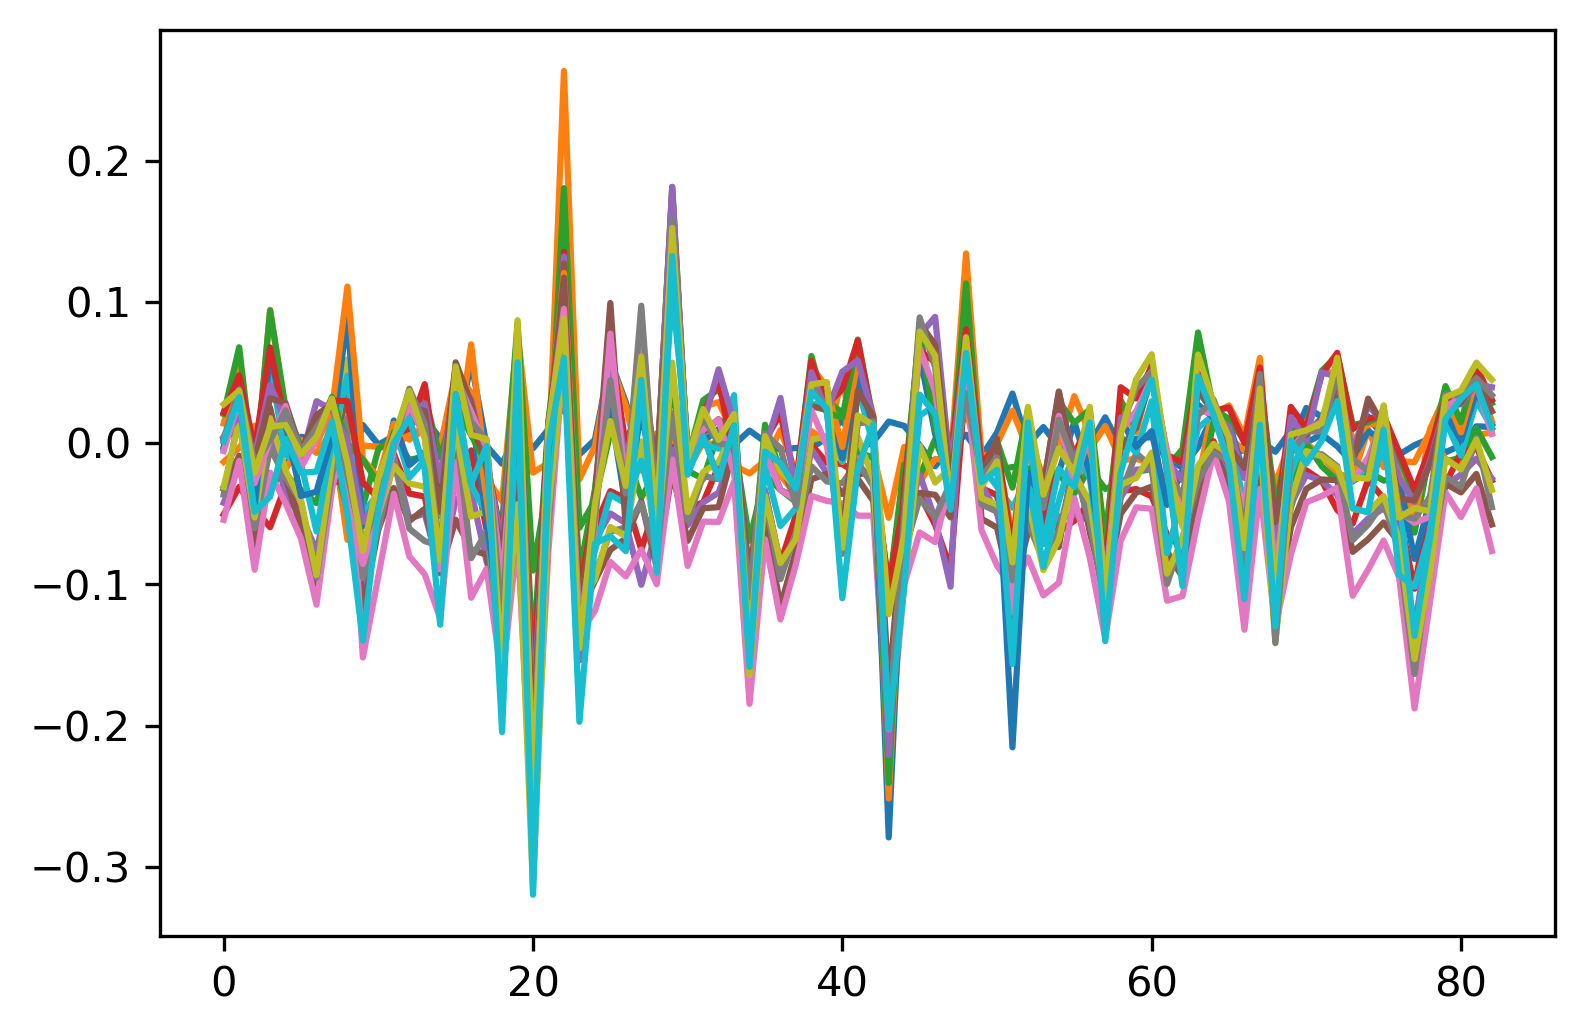

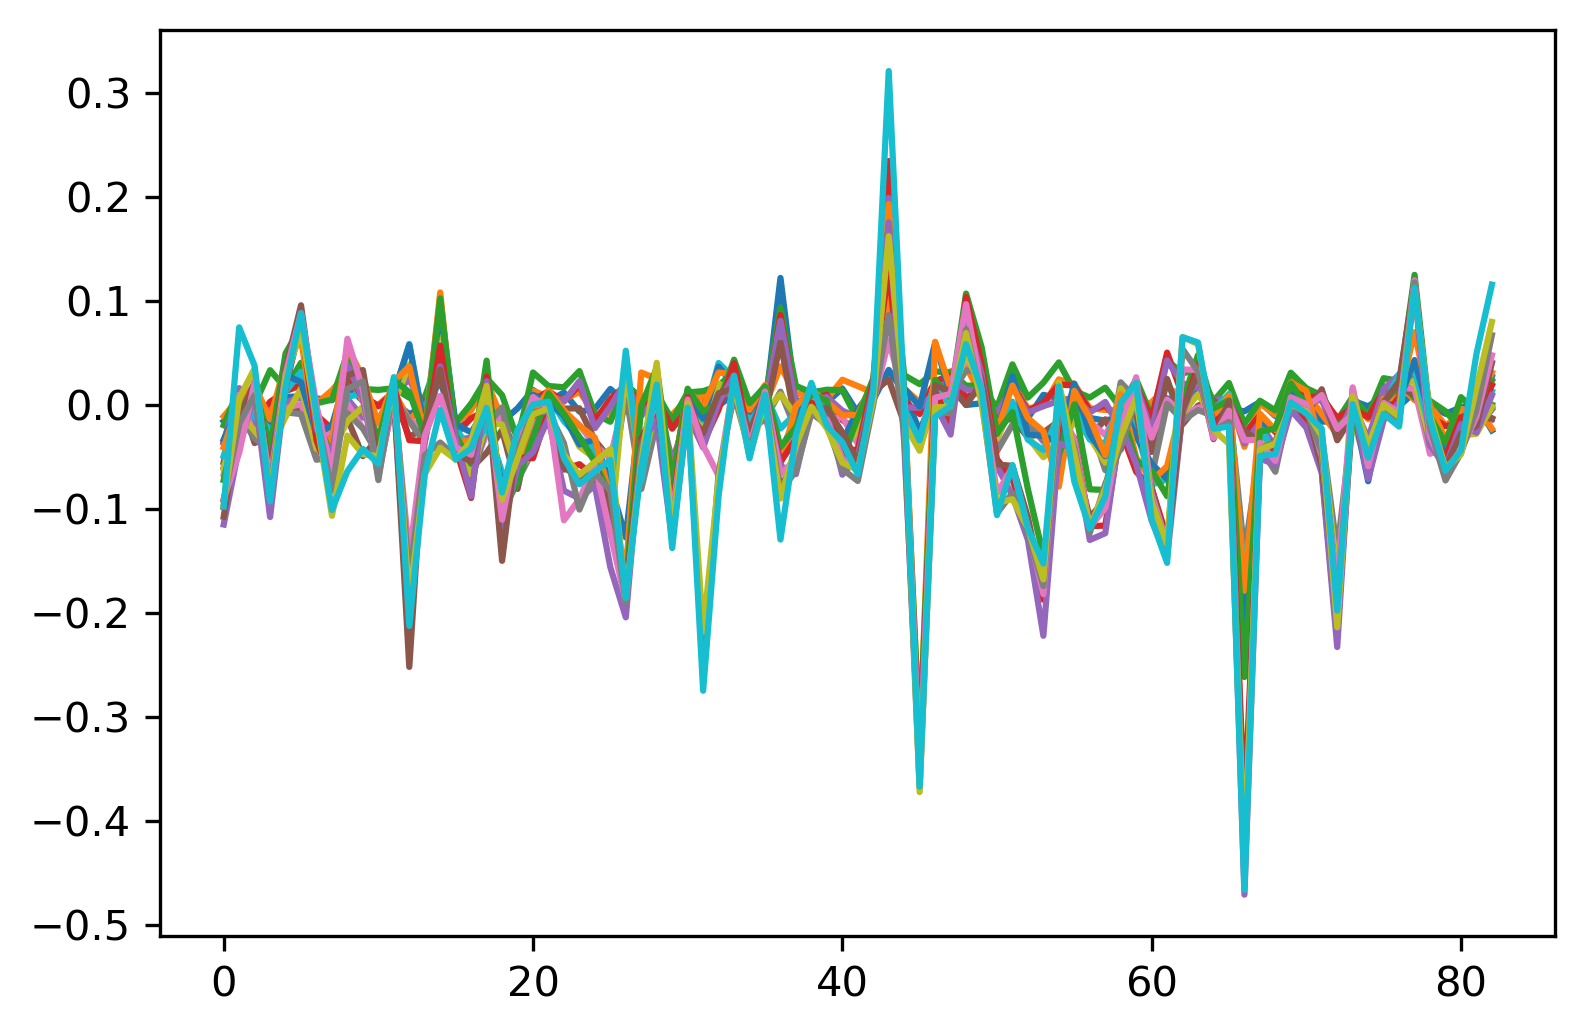

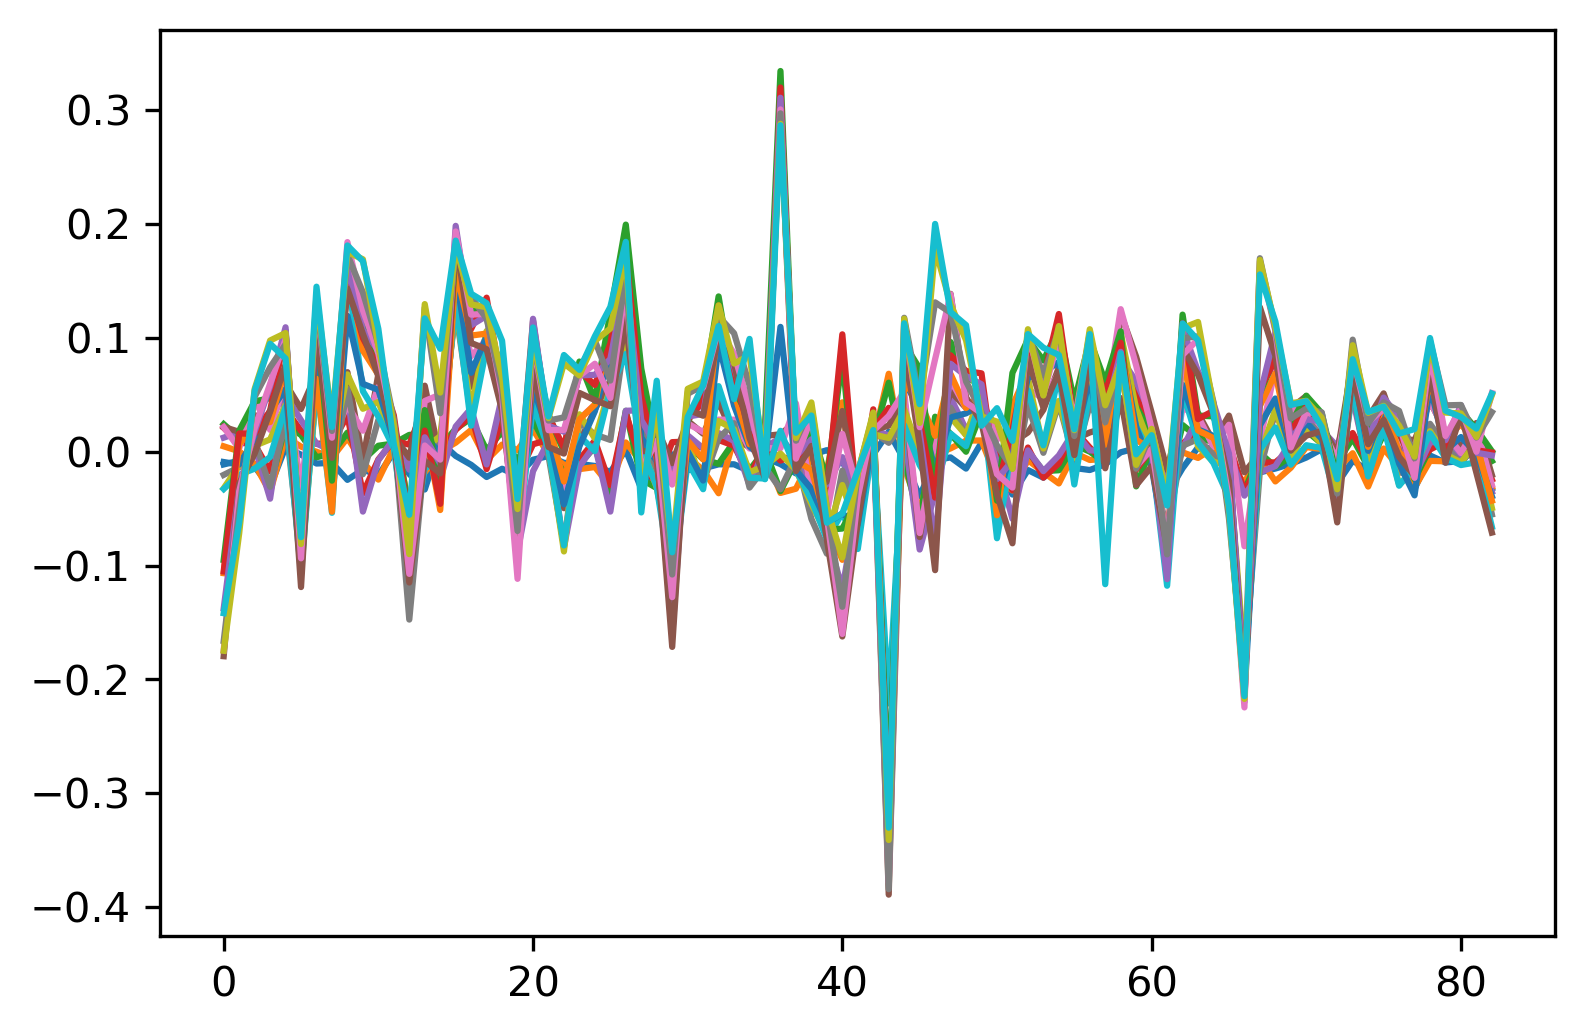

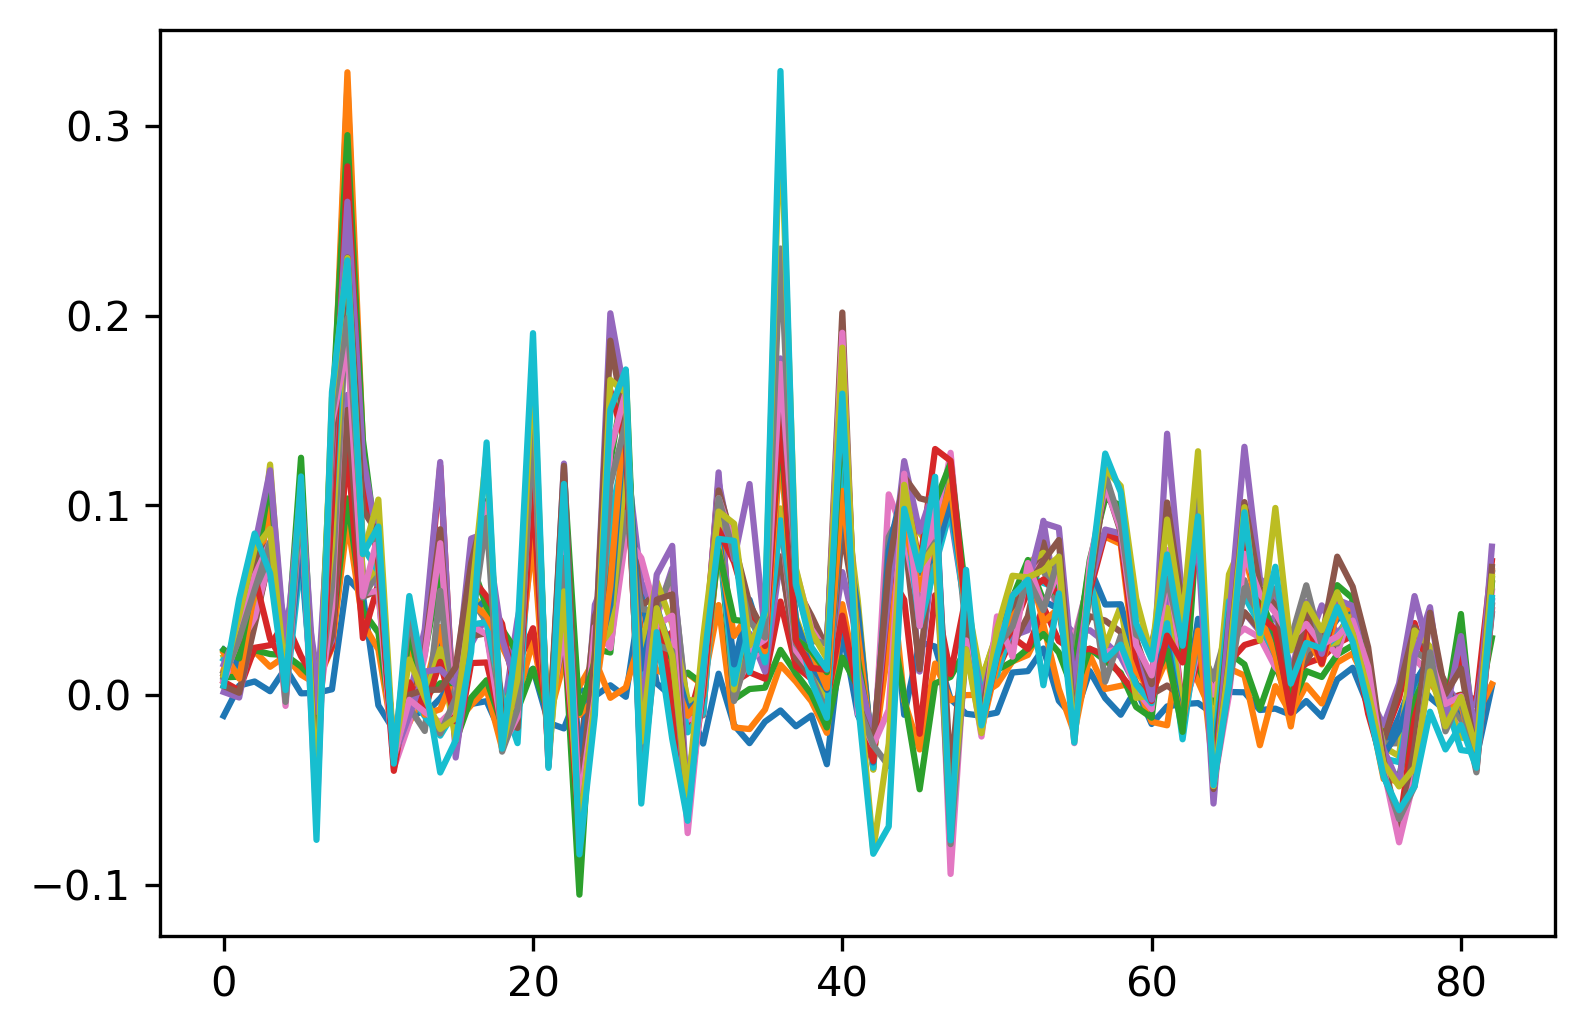

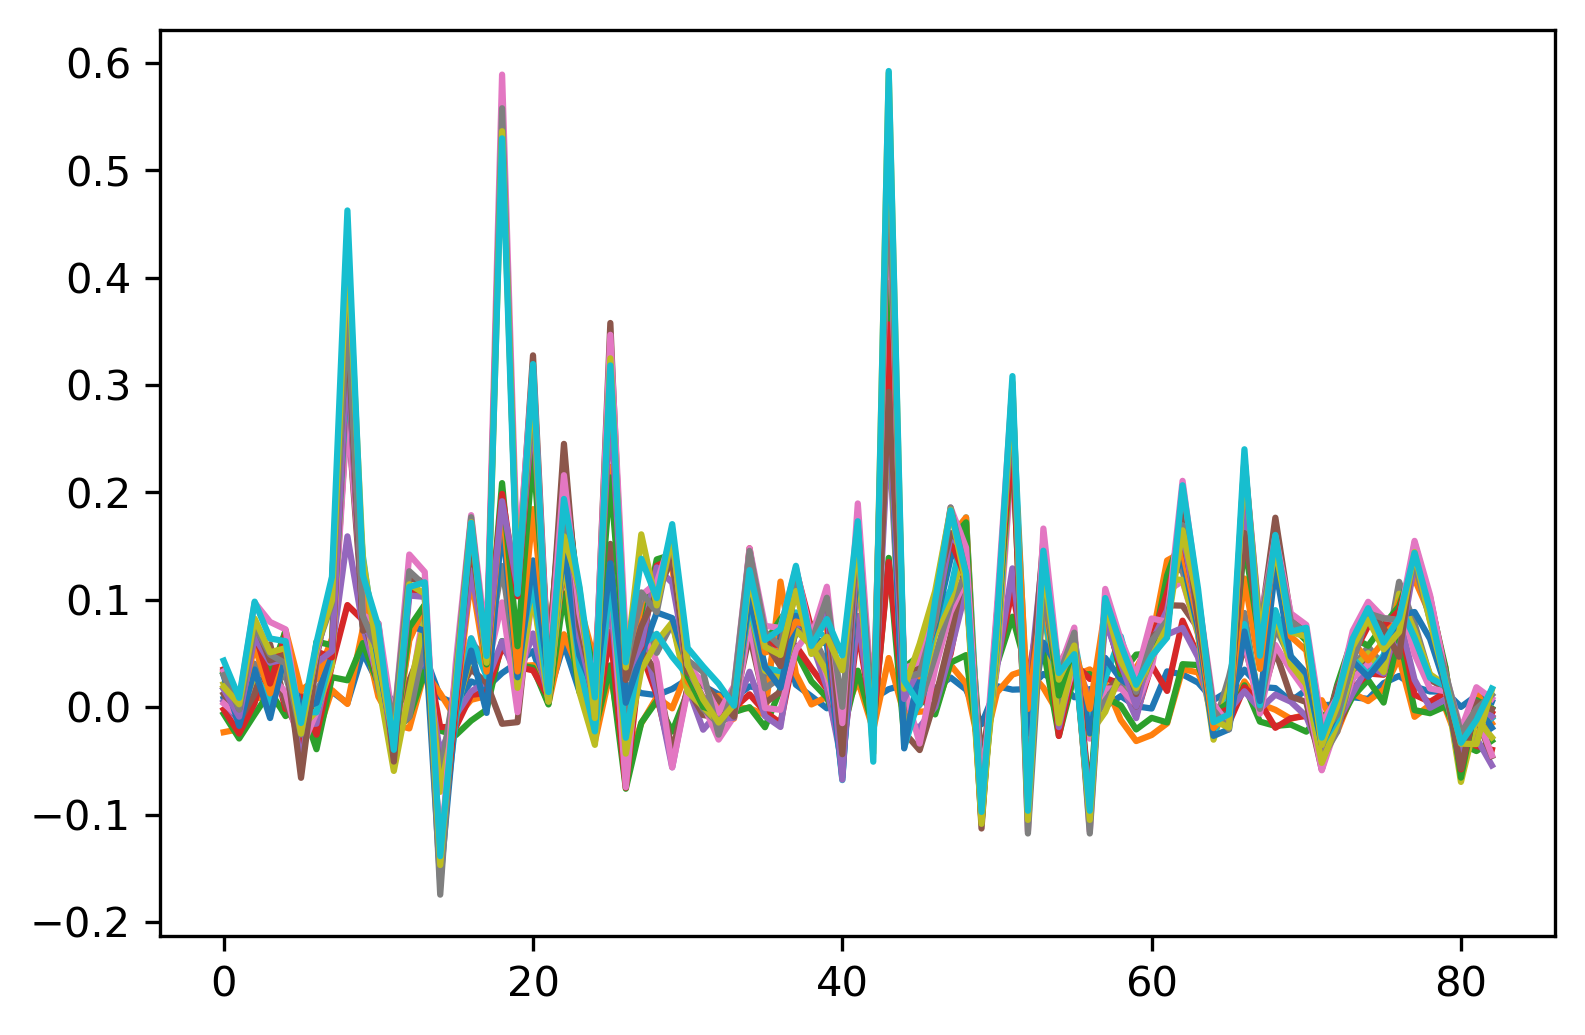

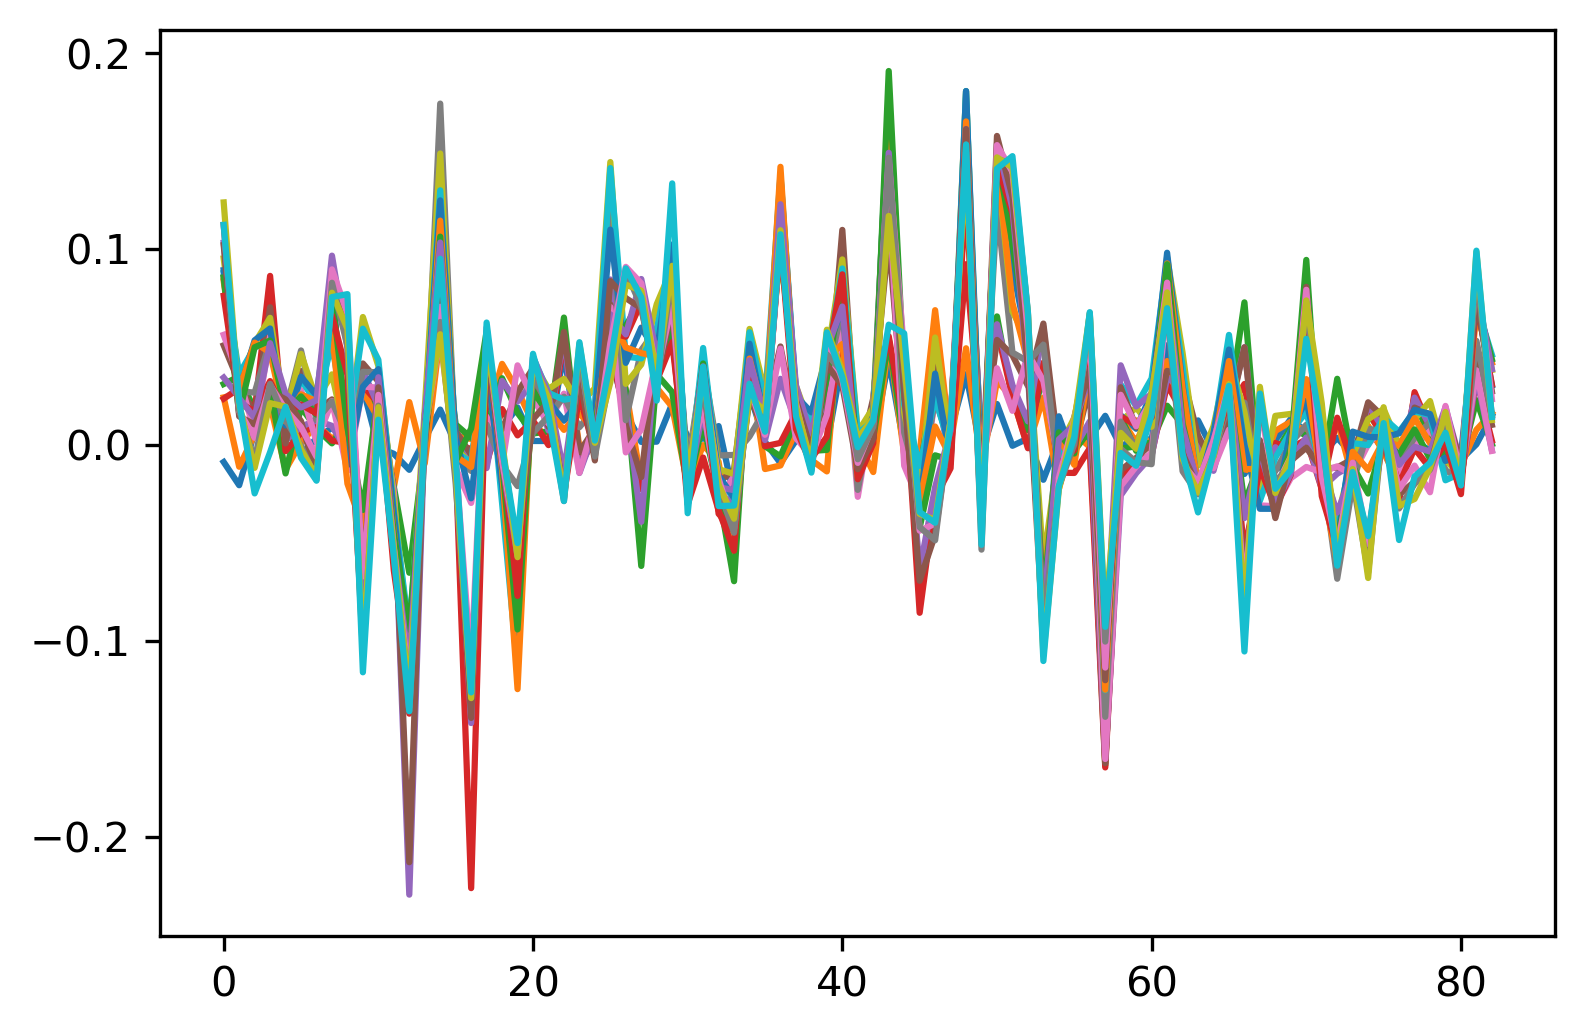

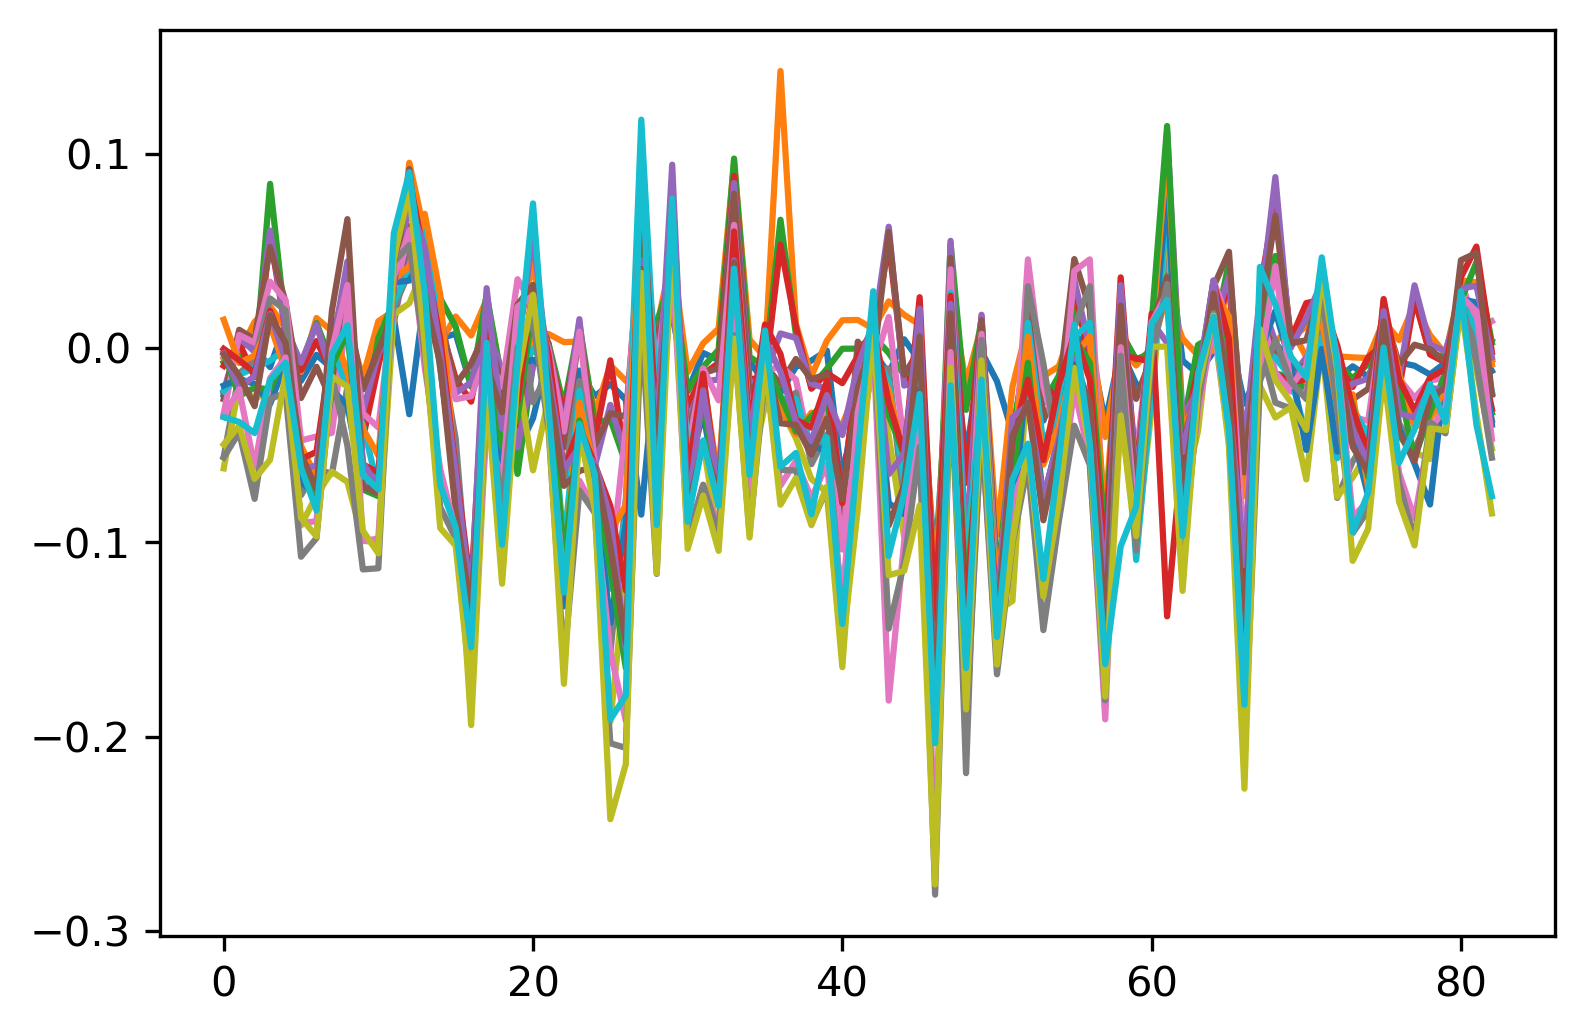

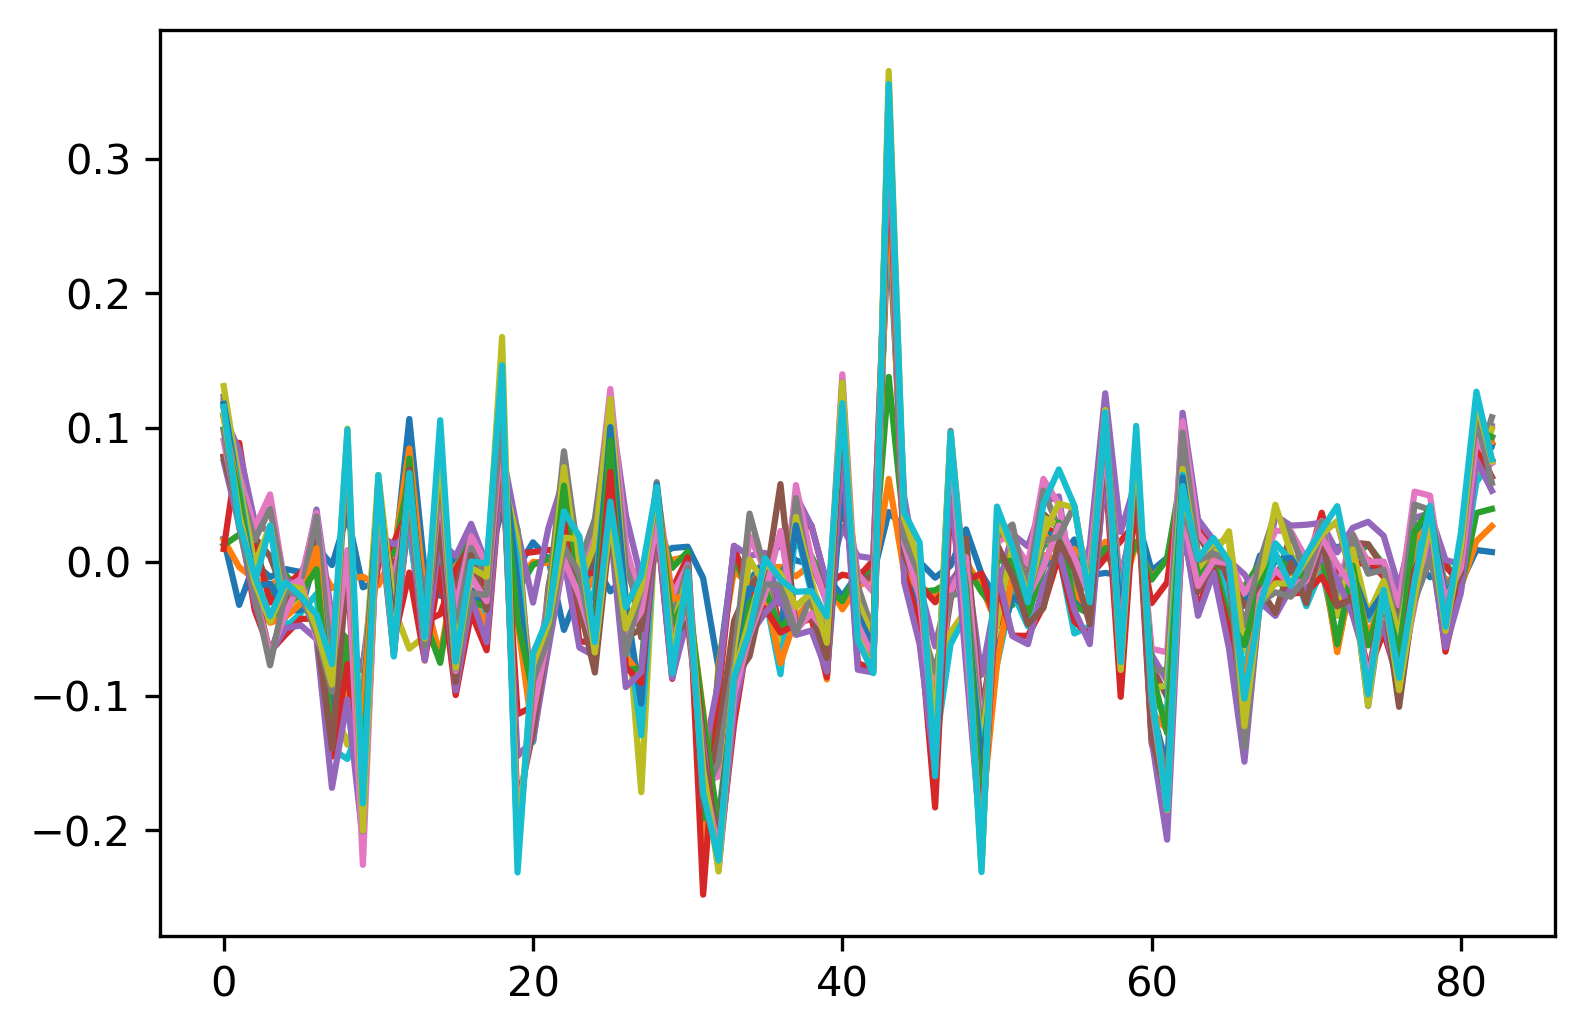

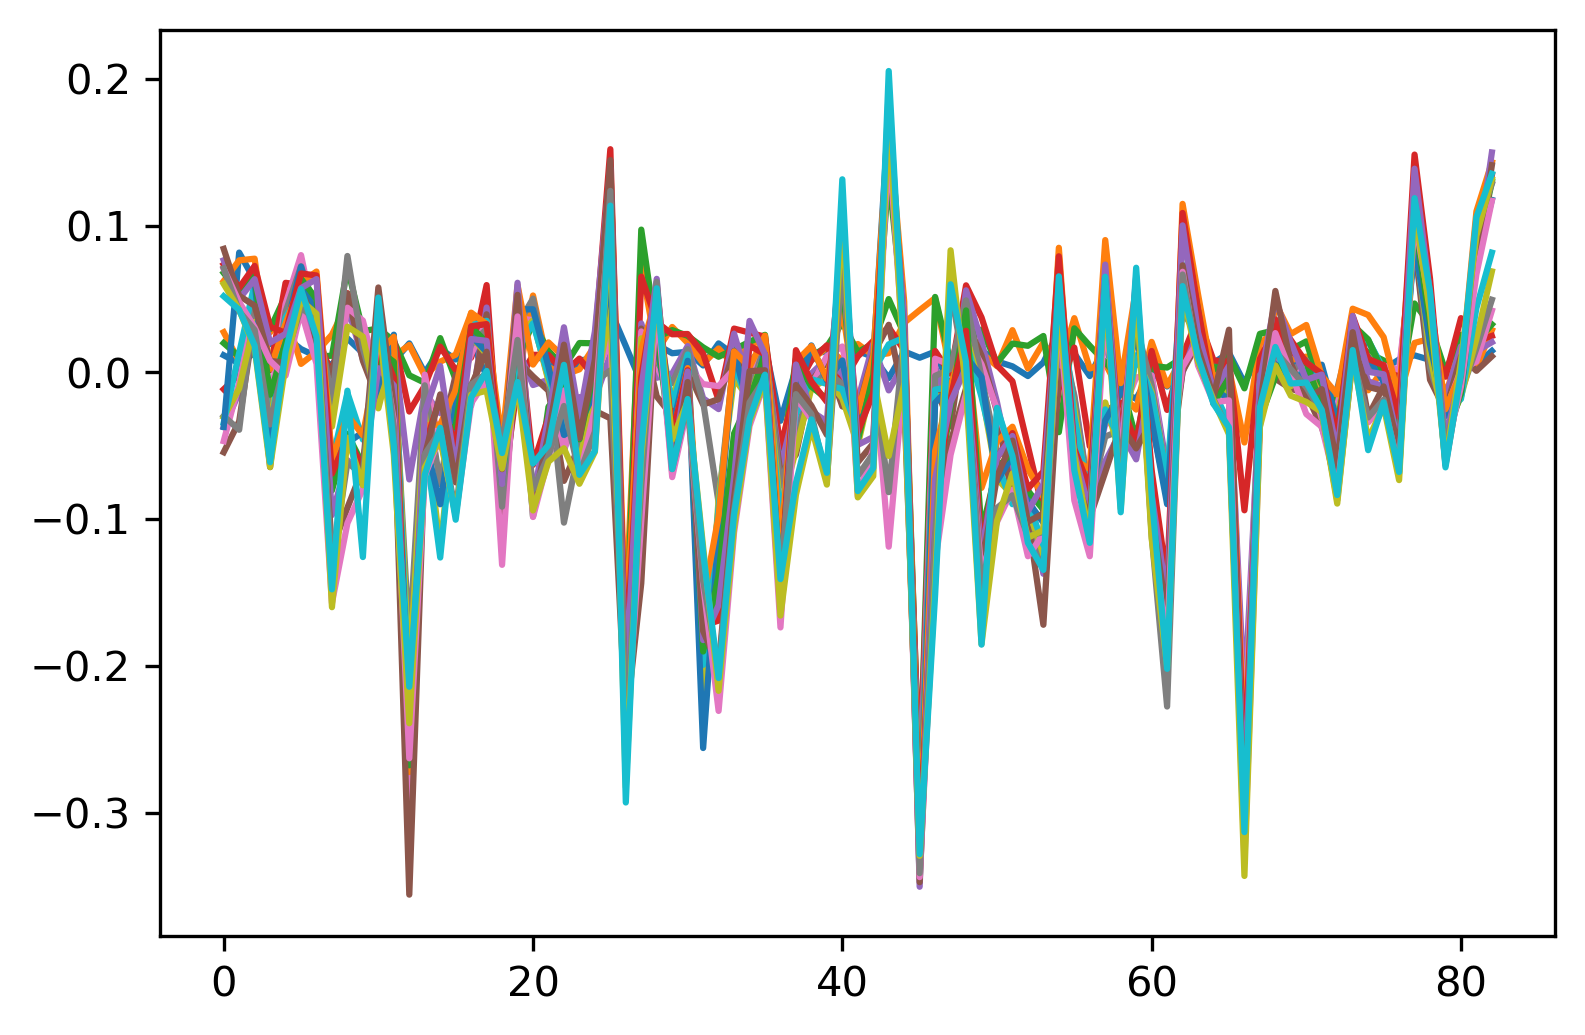

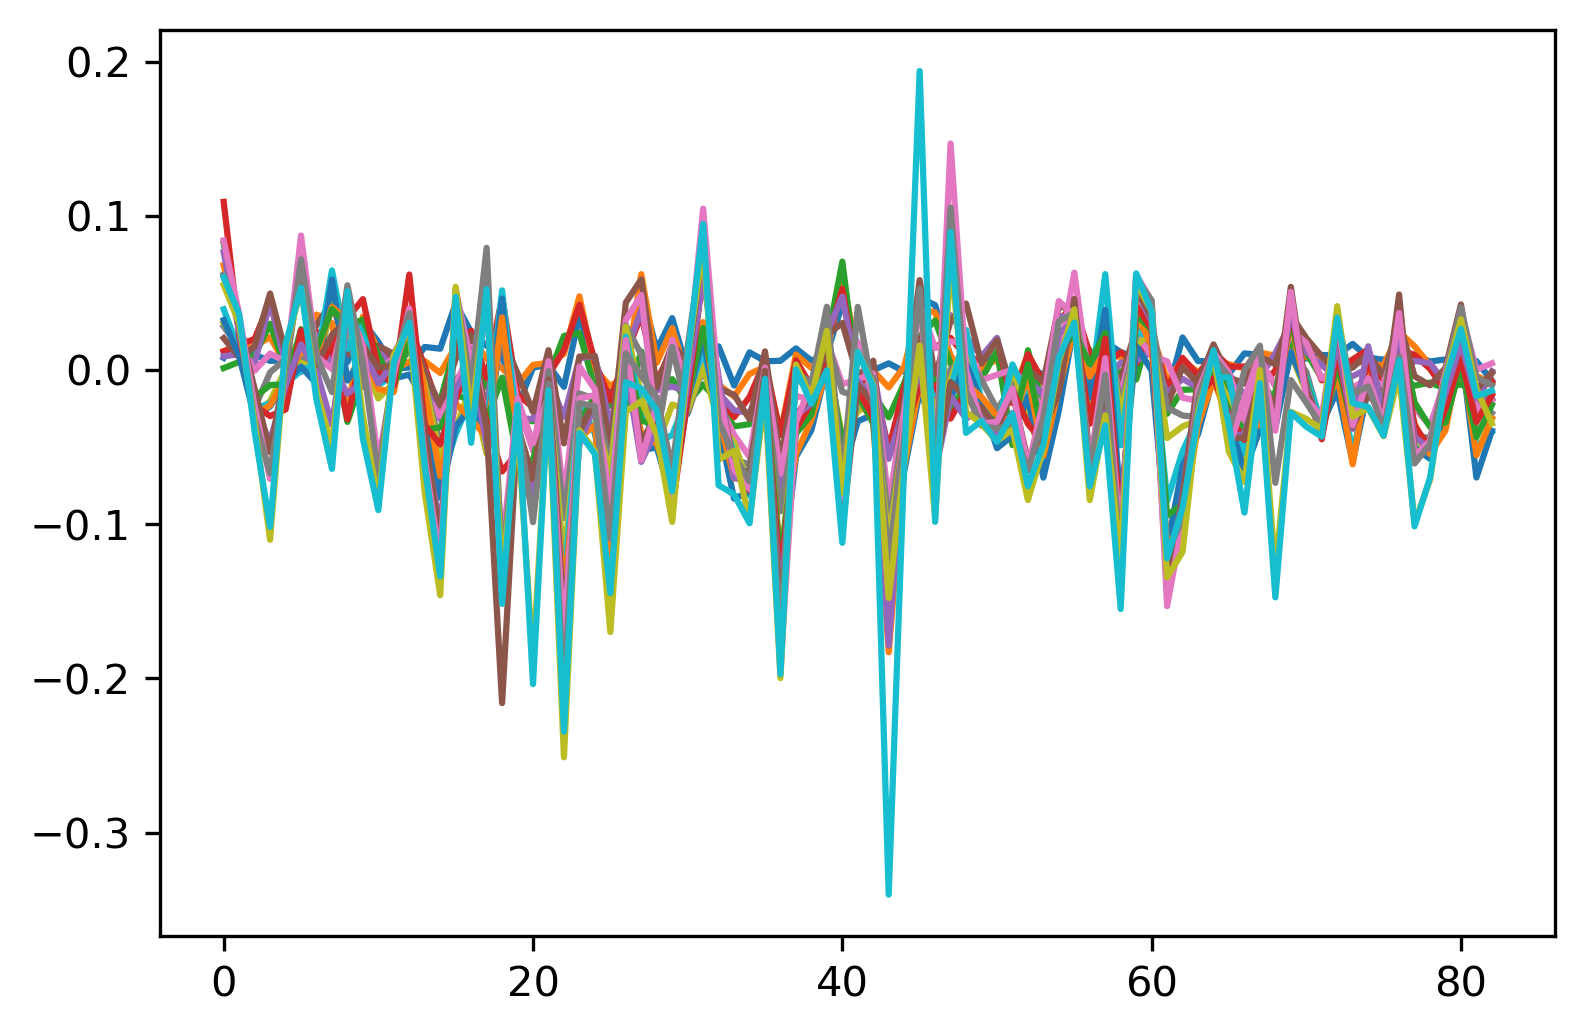

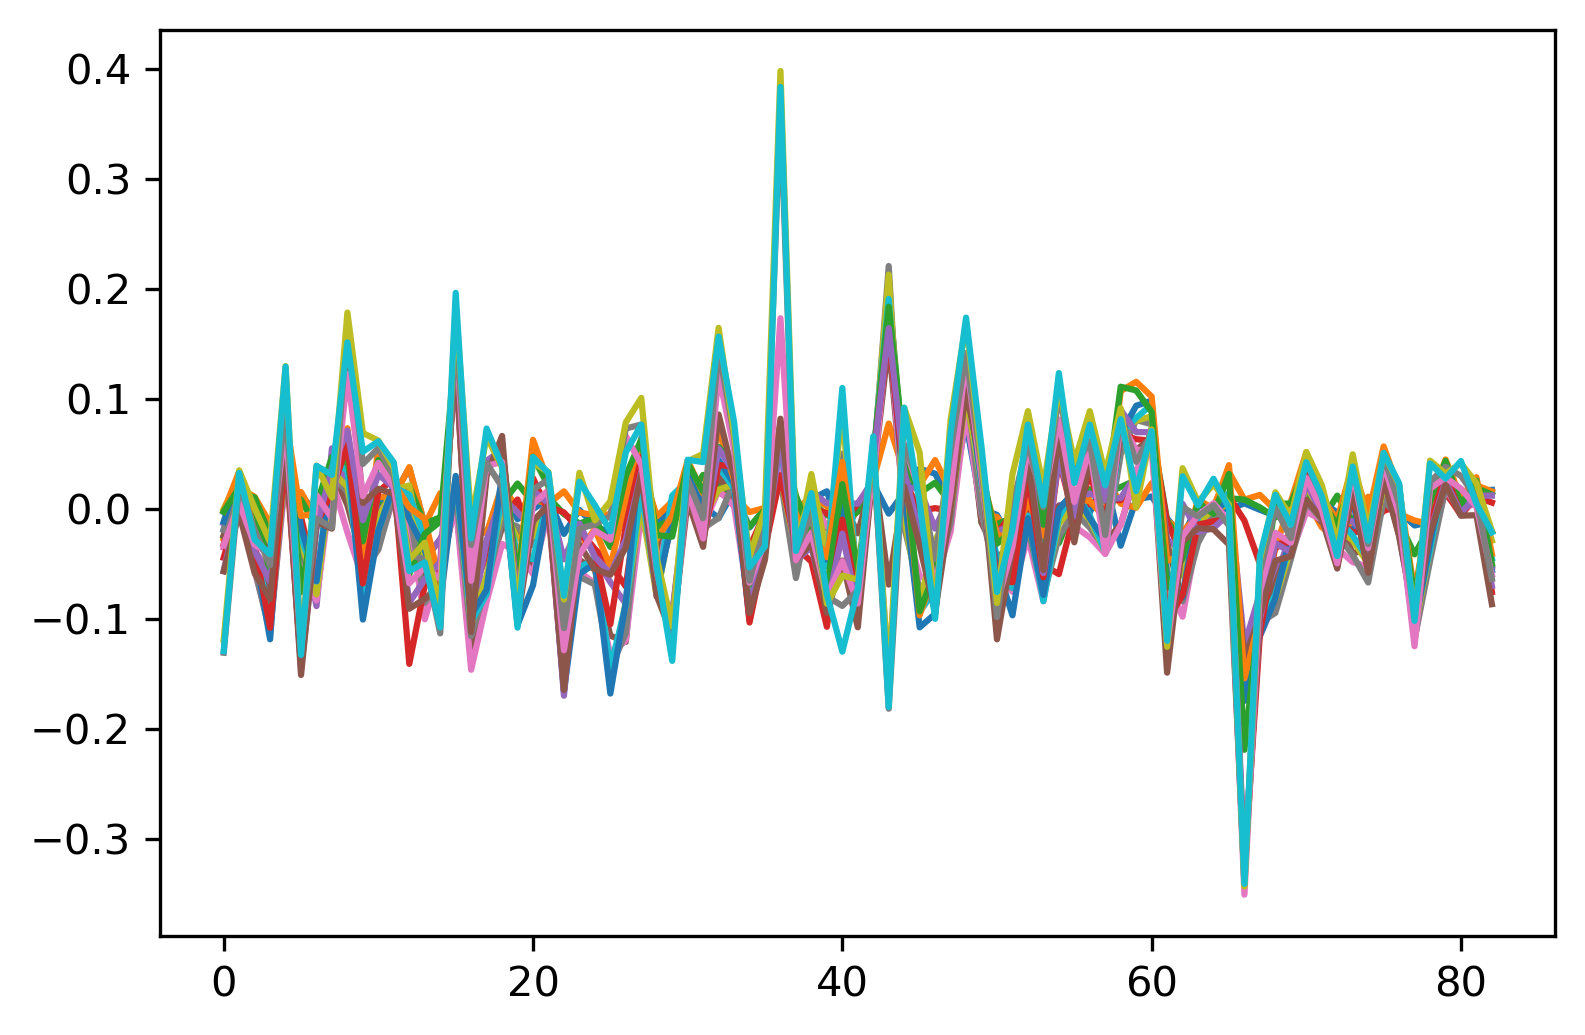

NameError: name 'uhi' is not defined

In [7]:
def rank_loss(prediction, ground_truth):
    all_one = torch.ones(prediction.shape[0], 1, dtype=torch.float32).to(device)
    prediction = prediction.unsqueeze(dim=1)
    ground_truth = ground_truth.unsqueeze(dim=1)
    #print(prediction.shape, ground_truth.shape, base_price.shape)
    return_ratio = prediction - 1
    true_return_ratio = ground_truth - 1

    pre_pw_dif = torch.sub(
        return_ratio @ all_one.t(),                  # C x C
        all_one @ return_ratio.t()                   # C x C
    )
    gt_pw_dif = torch.sub(
        all_one @ true_return_ratio.t(),
        true_return_ratio @ all_one.t()
    )

    rank_loss = torch.mean(
        F.relu(-1*pre_pw_dif * gt_pw_dif )
    )
   
    return rank_loss 

def evaluate(prediction, ground_truth, K):
    return_ratio = prediction - 1
    true_return_ratio = ground_truth - 1

    #print("True top k: ", torch.topk(true_return_ratio.squeeze(), k=3, dim=0))
    #print("Predicted top k: ", torch.topk(return_ratio.squeeze(), k=3, dim=0))
    
    obtained_return_ratio = true_return_ratio[torch.topk(return_ratio, k=K, dim=0)[1]].mean()

    #return_ratio = -1*return_ratio
    #obtained_return_ratio += true_return_ratio[torch.topk(return_ratio.squeeze(), k=K, dim=0)[1]].mean()
    #obtained_return_ratio /= 2

    target_obtained_return_ratio = torch.topk(true_return_ratio, k=K, dim=0)[0].mean()

    expected_return_ratio = torch.topk(return_ratio.squeeze(), k=K, dim=0)[0].mean()

    random = torch.randint(0, prediction.shape[0]-1, (K,))
    random_return_ratio = true_return_ratio[random].mean()

    a_cat_b, counts = torch.cat([torch.topk(return_ratio.squeeze(), k=K, dim=0)[1], torch.topk(true_return_ratio.squeeze(), k=K, dim=0)[1]]).unique(return_counts=True)
    accuracy = a_cat_b[torch.where(counts.gt(1))].shape[0] / K

    return obtained_return_ratio, target_obtained_return_ratio, expected_return_ratio, random_return_ratio, accuracy


top_k_choice = [1, 3, 5, 10]

# ----------- Main Training Loop -----------
def predict(loader, desc):
    epoch_loss, mape, move_loss, rmse_returns_loss, mae_loss = 0, 0, 0, 0, 0
    mini, maxi = float("infinity"), 0
    rr, true_rr, exp_rr, ran_rr, accuracy = torch.zeros(4).to(device), torch.zeros(4).to(device), torch.zeros(4).to(device), torch.zeros(4).to(device), torch.zeros(4).to(device)
    
    #tqdm_loader = tqdm(loader) 
    yb_store, yhat_store, yb_store2 = [], [], []
    ii = 0
    for xb, company, yb, scale, move_target in loader:
        xb      = torch.log(xb.to(device))
        yb      = yb.to(device) 
        scale   = scale.to(device)
        move_target = move_target.to(device)

        mpl.rcParams['figure.dpi']= 300
        plt.plot(np.array(xb[:, :, 0].cpu()))
        #plt.plot(np.array(yhat_store).reshape(-1, num_nodes)[:, 0], c='b')
        #plt.savefig("plots/saturation/R"+ str(RUN)+"-E"+str(ep)+"-T"+str(tau)+ ".png")
        plt.show()
        plt.close()
        ii += 1
        if ii > 10:
            uhi
        continue

        sjf
        y_hat, kg_loss, hold_pred = model(xb, yb, graph_data, relation_kg)
        y_hat = F.softmax(y_hat.squeeze(), dim = 0)
        true_return_ratio = yb.squeeze() 

        target = torch.topk(true_return_ratio, k=10, dim=0)[1]
        zeros = torch.zeros_like(y_hat)
        zeros[target] = 1

        #loss = F.mse_loss(y_hat, true_return_ratio) #+ rank_loss(y_hat, true_return_ratio)
        loss = F.binary_cross_entropy(y_hat, zeros)
        if USE_KG:
            loss += kg_loss.mean()

        if model.training:
            loss.backward()
            #nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            opt_c.step()
            opt_c.zero_grad()
        
        hold_pred = hold_pred.squeeze()
        yb_store.extend(list(hold_pred[:, 0].squeeze().detach().cpu().numpy()))
        yb_store2.extend(list(hold_pred[:, 1].squeeze().detach().cpu().numpy()))
        yhat_store.extend(list(zeros.detach().cpu().numpy()))
        
        for index, k in enumerate(top_k_choice):
            crr, ctrr, cerr, crrr, cacc = evaluate(y_hat, true_return_ratio, k)
            ran_rr[index] += crrr
            true_rr[index] += ctrr
            rr[index] += crr
            exp_rr[index] += cerr
            accuracy[index] += cacc

        mae_loss += F.l1_loss(y_hat, true_return_ratio).item()
        rmse_returns_loss += F.mse_loss(y_hat, true_return_ratio).item()
        mape += mean_absolute_percentage_error(y_hat, true_return_ratio)

        move_pred = torch.where(y_hat >= 1, 1, 0)
        move_loss += (move_pred.int() == move_target).float().mean()

        mini = min(mini, y_hat.min().item())
        maxi = max(maxi, y_hat.max().item())  
        loss = F.binary_cross_entropy(y_hat, zeros)
        epoch_loss += float(loss)
    
    epoch_loss /= len(loader)
    rmse_returns_loss /= len(loader)
    move_loss  /= len(loader)
    mape /= len(loader)
    rr /= len(loader) 
    true_rr /= len(loader)
    exp_rr /= len(loader)
    ran_rr /= len(loader)
    accuracy /= len(loader)
    mae_loss /= len(loader)

    #print(model.fc3.weight, model.fc3.bias)
    print("[{0}] Movement Prediction Accuracy: {1}, MAPE: {2}".format(desc, move_loss.item(), mape.item()))
    print("[{0}] Range of predictions min: {1} max: {2}".format(desc, mini, maxi))
    print("[{0}] Epoch: {1} MSE: {2} RMSE: {3} Loss: {4} MAE: {5}".format(desc, ep+1, rmse_returns_loss, rmse_returns_loss ** (1/2), epoch_loss, mae_loss))
    
    for index, k in enumerate(top_k_choice):
        print("[{0}] Top {5} Return Ratio: {1} True Return Ratio: {2} Expected Return Ratio: {3} Random Return Ratio: {4} Accuracy: {6}".format(desc, rr[index], true_rr[index], exp_rr[index], ran_rr[index], k, accuracy[index]))
    
    log = {'MSE': epoch_loss, 'RMSE': epoch_loss ** (1/2), "MOVEMENT ACC": move_loss, "MAPE": mape}
    
    if LOG:
        wandb.log(log)
    PLOT = True
    if PLOT:
        mpl.rcParams['figure.dpi']= 300
        plt.scatter(np.array(yb_store), np.array(yb_store2), c=np.array(yhat_store))
        #plt.plot(np.array(yhat_store).reshape(-1, num_nodes)[:, 0], c='b')
        plt.savefig("plots/saturation/R"+ str(RUN)+"-E"+str(ep)+"-T"+str(tau)+ ".png")
        plt.close()

    return epoch_loss, rr, true_rr, exp_rr, ran_rr, move_loss, mape, accuracy, mae_loss



for tau in tau_choices:
    tau_pos = tau_positions.index(tau)

    print("Tau: ", tau, "Tau Position: ", tau_pos)

    # ----------- Batching the data -----------
    def collate_fn(instn):
        instn = instn[0]
        # df: shape: Companies x W+1 x 5 (5 is the number of features)
        df = torch.Tensor(np.array([x[0] for x in instn])).unsqueeze(dim=2)
        #df = torch.Tensor(np.array([x[1] for x in instn])).unsqueeze(dim=2) - torch.Tensor(np.array([x[2] for x in instn])).unsqueeze(dim=2)
        for i in range(1, 5):
            df1 = torch.Tensor(np.array([x[i] for x in instn])).unsqueeze(dim=2)
            df = torch.cat((df, df1), dim=2)
        
        #financials = [np.array(x[9]).squeeze() for x in instn]
        #for i in financials:
        #    if i.shape[0] != 39:
        #        print("yes", i.shape)
        #print(financials[0].shape)

        #financials = torch.Tensor(np.array(financials))
        #kjkj

        company = torch.Tensor(np.array([x[5] for x in instn])).long()
        
        # Shape: Companies x 1
        target = torch.Tensor(np.array([x[7][tau_pos] for x in instn]))

        # Shape: Companies x 1
        scale = torch.Tensor(np.array([x[8] for x in instn]))

        movement = target >= 1

        return (df, company, target, scale, movement.int())


    start_time = 0
    test_mean_rr, test_mean_trr, test_mean_err, test_mean_rrr = torch.zeros(4).to(device), torch.zeros(4).to(device), torch.zeros(4).to(device), torch.zeros(4).to(device)
    test_mean_move, test_mean_mape, test_mean_mae = 0, 0, 0

    test_mean_acc = torch.zeros(4).to(device)
    print(len(dataset))
    for phase in range(1, 24):
        print("Phase: ", phase)
        train_loader    = DataLoader(dataset[start_time:start_time+250], 1, shuffle=True, collate_fn=collate_fn, num_workers=1)
        val_loader      = DataLoader(dataset[start_time+250:start_time+300], 1, shuffle=True, collate_fn=collate_fn)
        test_loader     = DataLoader(dataset[start_time+300:start_time+400], 1, shuffle=False, collate_fn=collate_fn)

        start_time += 100

        model  = Transformer_Ranking(W, T, D_MODEL, N_HEAD, ENC_LAYERS, DEC_LAYERS, D_FF, DROPOUT, USE_POS_ENCODING, USE_GRAPH, HYPER_GRAPH, USE_KG, num_nodes)
        #print(model)
        model.to(device)

        opt_c = torch.optim.Adam(model.parameters(), lr = 1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
        #opt_c = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0, nesterov=True)

        prev_val_loss = float("infinity")
        for ep in range(MAX_EPOCH):
            print("Epoch: " + str(ep+1))
            
            model.train()
            train_epoch_loss, rr, trr, err, rrr, move, mape, accuracy, mae = predict(train_loader, "TRAINING")

            model.eval()
            with torch.no_grad():
                val_epoch_loss, rr, trr, err, rrr, move, mape, accuracy, mae  = predict(val_loader, "VALIDATION")

            #plot(val_loader)

            if (ep > MAX_EPOCH//2 or ep > 10) and prev_val_loss > val_epoch_loss:
                print("Saving Model")
                torch.save(model.state_dict(), "models/saved_models/best_model_"+INDEX+str(W)+"_"+str(T)+"_"+str(RUN)+".pt")
                prev_val_loss = val_epoch_loss

        model.load_state_dict(torch.load("models/saved_models/best_model_"+INDEX+str(W)+"_"+str(T)+"_"+str(RUN)+".pt"))

        model.eval()
        with torch.no_grad():
            test_epoch_loss, rr, trr, err, rrr, move, mape, accuracy, mae = predict(test_loader, "TESTING")
            test_mean_rr += rr
            test_mean_trr += trr
            test_mean_err += err
            test_mean_rrr += rrr
            test_mean_acc += accuracy
            test_mean_move += float(move)
            test_mean_mape += float(mape)
            test_mean_mae += float(mae)
            for index, k in enumerate(top_k_choice):
                print("[Mean - {0}] Top {5} Return Ratio: {1} True Return Ratio: {2} Expected Return Ratio: {3} Random Return Ratio: {4} Accuracy: {6}".format("TESTING", test_mean_rr[index]/phase, test_mean_trr[index]/phase, test_mean_err[index]/phase, test_mean_rrr[index]/phase, k, test_mean_acc[index]/phase))
            print("[Mean - {0}] Movement Accuracy: {1} Mean MAPE: {2} Mean MAE: {3}".format("TESTING", test_mean_move/phase, test_mean_mape/phase, test_mean_mae/phase))
        if LOG:
            wandb.save('model.py')

    phase = 23
    print("Tau: ", tau)
    for index, k in enumerate(top_k_choice):
        print("[Mean - {0}] Top {5} {1} {2} {3} {4} {6}".format("TESTING", test_mean_rr[index]/phase, test_mean_trr[index]/phase, test_mean_err[index]/phase, test_mean_rrr[index]/phase, k, test_mean_acc[index]/phase))
    print("[Mean - {0}] {1} {2} {3}".format("TESTING", test_mean_move/phase, test_mean_mape/phase, test_mean_mae/phase))
    break